Uses a prompted BERT to learn a metric between passage and query with the goal of solving the passage retrieval task in MS MARCO https://microsoft.github.io/msmarco/

This approach was inspired by https://aclanthology.org/D19-1352.pdf and their usage of something similar to a prompted BERT to perform passage retrieval, we experiment with adding a prompt and taking input at the mask token

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertModel, BertTokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data Exploration
The dataset is massive, near 26GB. Note we use the triples version of the dataset, designed to be convenient for training, which provides triples of the form (query, relevant passage, non relevant passage)

In [2]:
df = pd.read_csv('Datasets/triples.train.small.tsv', sep='\t', nrows=10000, # only read a small sample of the data for now 
                 names=["query", "positive", "negative"], encoding="utf-8") 
df

,query,positive,negative
0,is a little caffeine ok during pregnancy,We donât know a lot about the effects of caf...,It is generally safe for pregnant women to eat...
1,what fruit is native to australia,Passiflora herbertiana. A rare passion fruit n...,"The kola nut is the fruit of the kola tree, a ..."
2,how large is the canadian military,The Canadian Armed Forces. 1 The first large-...,The Canadian Physician Health Institute (CPHI)...
3,types of fruit trees,Cherry. Cherry trees are found throughout the ...,"The kola nut is the fruit of the kola tree, a ..."
4,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,...","However, you still need some niacin each day; ..."
...,...,...,...
9995,what does petsmart pay part time,Petsmart-About $7 (for a grooming bather or ca...,What is double-time pay? Double-time pay is a ...
9996,what does dystopian mean,Top definition. dystopian. A dystopia (alterna...,(film) Equilibrium is a 2002 American dystopia...
9997,when is a partnership return due,1 Partnership and S Corporation tax returns wi...,"â¢ With decreased stroke volume, due to decre..."
9998,what type of cable is used between switches ?,No thats not possible. Only if you have auto-m...,"1-16 of 1,177 results for verizon network type..."


In [3]:
df.iloc[0]["positive"]

'We donâ\x80\x99t know a lot about the effects of caffeine during pregnancy on you and your baby. So itâ\x80\x99s best to limit the amount you get each day. If youâ\x80\x99re pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.'

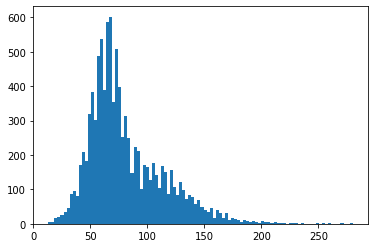

In [4]:
# plot a passage length histogram
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
lengths = df["positive"].apply(lambda x: len(tokenizer.encode(x)))
plt.hist(lengths, bins=100)
plt.show()

In [5]:
max_length=256 # from the plot we can see a batch size of 256 is more than enough to represent most passages

In [6]:
# Create a train test split by first creating a dataset with query, sample and label. Then splitting it
positive = df[["query", "positive"]].rename(columns={"positive": "passage"})
positive["label"] = 1
negative = df[["query", "negative"]].rename(columns={"negative": "passage"})
negative["label"] = 0
dataset = pd.concat([positive, negative], axis=0).reset_index(drop=True)
dataset = dataset.sample(20000, replace=False)
X_train, X_test, y_train, y_test = train_test_split(dataset[["query", "passage"]], np.array(dataset["label"]), test_size=0.2)

In [7]:
X_train

,query,passage
4769,how many bundles of shingles in a square,"The most common type of shingles, known as str..."
7968,what is the name of the turkey neck,A turkey neck is the slang term that has been ...
6678,how long do you microwave a potato to cook it,"1 If you prefer crispy skinned sweet potatoes,..."
13510,who pays for kidney transplant,Ciprofloxacin may cause swelling or tearing of...
2868,when was a man called ove released,A Man Called Ove (Swedish: En man som heter Ov...
...,...,...
11128,what is appropriate in your field dress,Dress. When you create a dress code policy for...
9089,where is stow ohio located,"Stow is a city in Summit County, Ohio, United ..."
8642,how many species of deer,Itâs thought there are more than two million...
6610,define skeleton,skeleton. 1 the hard framework of an animal b...


# Modelling
Define the dataset class and a BERT_prompt class, with prompting logic in the dataset for speed

In [8]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
tokenizer.encode("Hello " + tokenizer.mask_token)

[101, 7592, 103, 102]

In [10]:
# Define a dataset class for prompted BERT fine tuning
# The dataset takes in query and passage, and then construct a training sample as: <query> + <prompt> + [MASK] + <passage>, returning the position of the mask
# It also performs padding and stores the labels
class BERTPromptDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, labels, tokenizer, prompt="Is the following text relevant?", max_length=max_length):
        # Construct the input sentence
        input_sentences = ["{}. {} {} {}".format(query, prompt, tokenizer.mask_token, passage) for _, (query, passage) in dataset.iterrows()]
        
        # Encode and store
        encodings_dict = tokenizer.batch_encode_plus(input_sentences, truncation=True, max_length=max_length, padding="max_length")
        self.input_ids = encodings_dict['input_ids']
        self.attn_masks = encodings_dict['attention_mask']
        self.labels = labels

        # Calculate the position of the mask using self.input_ids
        mask_id = tokenizer.encode(tokenizer.mask_token)[1] # 103
        self.mask_pos = [sent_ids.index(mask_id) for sent_ids in self.input_ids]
        
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return_dict = {"input_ids": torch.tensor(self.input_ids[idx]),
                       "attention_mask": torch.tensor(self.attn_masks[idx]), 
                       "mask_pos": torch.tensor(self.mask_pos[idx]),
                       "labels": torch.tensor(self.labels[idx]).float()} 
        return return_dict

In [11]:
dataset = BERTPromptDataset(X_train, y_train, tokenizer)
dataset[0:10]

{'input_ids': tensor([[ 101, 2129, 2116,  ...,    0,    0,    0],
         [ 101, 2054, 2003,  ...,    0,    0,    0],
         [ 101, 2129, 2146,  ...,    0,    0,    0],
         ...,
         [ 101, 2054, 2193,  ...,    0,    0,    0],
         [ 101, 6032, 3465,  ...,    0,    0,    0],
         [ 101, 2129, 2000,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'mask_pos': tensor([17, 16, 18, 13, 16, 21, 13, 12, 14, 16]),
 'labels': tensor([1., 1., 1., 0., 1., 0., 0., 0., 1., 1.])}

In [12]:
# Class that expects a prompted input from the BERTPromptDataset
# Takes the input, forward propagates it through BERT and concatenates the output at the [MASK] and [CLS] token to get a representation of the text
# This is then passed to a linear head to perform binary classification for how relevant it is
class BERTPrompt(torch.nn.Module):
    def __init__(self, bert, tokenizer):
        super().__init__()
        self.bert = bert.cuda()
        self.tokenizer = tokenizer
        self.linear = torch.nn.Linear(768*2, 1).cuda()
        self.act = torch.nn.Sigmoid()
        
    # input_dict is obtained through indexing the dataset e.g. dataset[0:10]
    def forward(self, input_dict):
        output = self.bert(input_dict["input_ids"].cuda(), attention_mask=input_dict['attention_mask'].cuda())[0] # output is of shape [10, 256, 768]
        cls_out = output[:, 0, :]
        mask_out = output[torch.arange(cls_out.shape[0]).cuda(), input_dict["mask_pos"].cuda(), :] # indexing like [[0, 1], [13, 14]] will select items [[0, 13], [1, 14]]
        
        representation = torch.cat([cls_out, mask_out], dim=1)
        logit = self.linear(representation)
        return logit
    
    # return the logit with sigmoid activation applied
    def predict(self, input_dict):
        return self.act(self.forward(input_dict))

In [30]:
bert_prompt = BERTPrompt(bert, tokenizer)

In [14]:
with torch.no_grad():
    output = bert_prompt.forward(dataset[:10])
output

tensor([[ 0.2016],
        [ 0.1476],
        [ 0.1437],
        [ 0.2560],
        [-0.0234],
        [ 0.1067],
        [-0.0392],
        [ 0.0778],
        [ 0.0424],
        [ 0.0211]], device='cuda:0')

# Training
Train with the entire dataset. Few shot learning is not that much of a problem in document retrieval, more adaptation and generalization to queries that are often unique

In [33]:
torch.cuda.empty_cache()

In [34]:
def calc_accuracy(model, test_dataset):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch_i in range(int(len(test_dataset)/batch_size)):
            batch = test_dataset[batch_i*batch_size: (batch_i+1)*batch_size]
            preds += list(bert_prompt.predict(batch)[:, 0].cpu().numpy())
            labels += list(batch["labels"].cpu().numpy())
    return accuracy_score(np.array(preds) > 0.5,  np.array(labels))

In [36]:
train_dataset = BERTPromptDataset(X_train[:1000], y_train[:1000], tokenizer)
test_dataset = BERTPromptDataset(X_test[:1000], y_test[:1000], tokenizer)
optimizer = torch.optim.Adam(bert_prompt.parameters(), lr=1e-5, betas=(0.95, 0.9995))
loss_func = torch.nn.BCELoss()
epochs = 1
batch_size = 16
bert_prompt = BERTPrompt(bert, tokenizer)

In [37]:
for epoch in range(epochs):  
    bert_prompt.train()
    for batch_i in range(int(len(train_dataset)/batch_size)): # just ignore the final partial batch
        bert_prompt.zero_grad()
        batch = train_dataset[batch_i*batch_size: (batch_i+1)*batch_size]
        preds = bert_prompt.predict(batch) # gives outputs with sigmoid activation
        loss = loss_func(preds[:, 0], batch["labels"].cuda())
        loss.backward()
        optimizer.step()
        
        if batch_i % 100 == 0:
            print("Batch {} Train Loss: {}".format(batch_i, loss))
        
    torch.cuda.empty_cache()
    accuracy = calc_accuracy(bert_prompt, test_dataset)
    print("Epoch {} Train Loss: {} Validation Accuracy: {}".format(epoch, loss, accuracy))

Batch 0 Train Loss: 0.8332217335700989
Epoch 0 Train Loss: 0.023418264463543892 Validation Accuracy: 0.8790322580645161


With prompt (1000 examples, 1 epoch): 0.879 accuracy

Without prompt (1000 examples, 1 epoch): 0.865 accuracy

This at least shows a better few shot learning potential, need to do more testing

<code>Batch 0 Train Loss: 0.10379621386528015
Epoch 0 Train Loss: 0.14899209141731262 Validation Accuracy: 0.8276209677419355
Batch 0 Train Loss: 0.013592392206192017
Epoch 1 Train Loss: 0.09803555905818939 Validation Accuracy: 0.8306451612903226
Batch 0 Train Loss: 0.0046791210770606995
Epoch 2 Train Loss: 0.02600925974547863 Validation Accuracy: 0.8215725806451613
Batch 0 Train Loss: 0.002842813730239868
Epoch 3 Train Loss: 0.03294769302010536 Validation Accuracy: 0.8004032258064516
Batch 0 Train Loss: 0.0033466718159615993
Epoch 4 Train Loss: 0.013205558061599731 Validation Accuracy: 0.8165322580645161
Batch 0 Train Loss: 0.004724848549813032
Epoch 5 Train Loss: 0.01365710236132145 Validation Accuracy: 0.8165322580645161
Batch 0 Train Loss: 0.003022630698978901
Epoch 6 Train Loss: 0.01209681760519743 Validation Accuracy: 0.8245967741935484
Batch 0 Train Loss: 0.004604271147400141
Epoch 7 Train Loss: 0.017215438187122345 Validation Accuracy: 0.8225806451612904
Batch 0 Train Loss: 0.0008006490534171462
Epoch 8 Train Loss: 0.019000805914402008 Validation Accuracy: 0.8195564516129032
Batch 0 Train Loss: 0.0017620337894186378
Epoch 9 Train Loss: 0.00176604138687253 Validation Accuracy: 0.8326612903225806</code>